In [7]:
# Copyright (c) 2022 rxn4chemistry 
# - Mark Martori Lopez
import glob
import cv2
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import os
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

##### Read Training Data Set

In [18]:
images = []
def imagesIds(path):
    for img in glob.glob(path+"*.png"):
        images.append(img) 
    return images
def getDF(path):
    """
    Returns dataframe format of training images.
    """
    listImgs = imagesIds(path)
    df = pd.DataFrame(listImgs, index=None)
    return df

df = getDF("../../real_data/real/")
df.iloc[2][0]

'../../real_data/real/debenzoyltashironin_2.png'

In [19]:
class Arrow(Dataset):
    def __init__(self,data, directory, transform = None):
        self.data      = data
        self.directory = directory
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        path  = os.path.join(self.directory, self.data.iloc[idx][0]) # import
        image = cv2.imread(path) #, cv2.COLOR_BGR2RGB)
            
        # augmentations
        if self.transform is not None:
            image = self.transform(image = image)['image']
        return image
augs = A.Compose([A.Resize(height = 512, width  = 512),A.Normalize(mean = (0, 0, 0),std  = (1, 1, 1)), ToTensorV2()])

##### Examine a sample batch

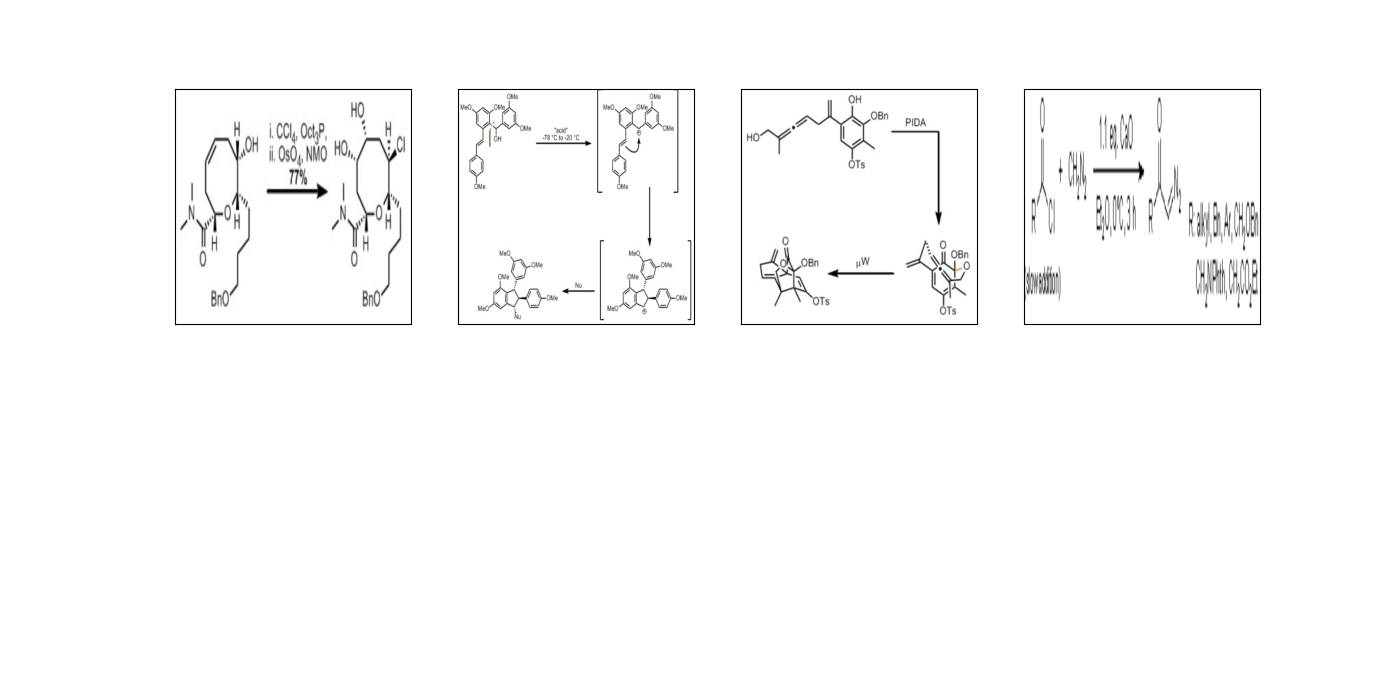

In [ ]:
# dataset
image_dataset = Arrow(data      = df, directory = '', transform = augs)

# USE THIS V FOR TRAINING IMAGES
"""# data loader
image_loader = DataLoader(image_dataset, batch_size  = 1, shuffle     = False)
                          
# display images
for batch_idx, inputs in enumerate(image_loader):
    fig = plt.figure(figsize = (14, 7))
    for i in range(8):
        ax = fig.add_subplot(2, 4, i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))"""

# USE THIS V FOR REAL IMAGES
image_loader = DataLoader(image_dataset, batch_size=4, shuffle=False)

for batch_idx, inputs in enumerate(image_loader):
    fig = plt.figure(figsize=(14, 7))
    num_images = inputs.shape[0]  # Actual number of images in this batch
    
    for i in range(num_images):  # Use actual batch size instead of fixed 8
        ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
    plt.show()
    break
    

##### Compute MEAN and STD

In [40]:
# placeholders
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])
# loop through images
c = 0
# loop through all images

    
for inputs in tqdm(image_loader): # 
    try:
        psum    += inputs.sum(axis        = [0, 2, 3])
        psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])
    except:
        print(f"{c} Images not found.")

100%|██████████| 7/7 [00:00<00:00, 77.68it/s]


In [41]:
# pixel count
count = len(df) * 512 * 512

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))
"""
[mean, std]: tensor([0.9717, 0.9717, 0.9717], [0.1345, 0.1345, 0.1345]) # Fort training images
[mean, std]: tensor([0.9572, 0.9566, 0.9567], [0.1564, 0.1578, 0.1573]) # For real images
"""

mean: tensor([0.9572, 0.9566, 0.9567])
std:  tensor([0.1564, 0.1578, 0.1573])


'\n[mean, std]: tensor([0.9717, 0.9717, 0.9717], [0.1345, 0.1345, 0.1345]) # Fort training images\n[mean, std]: tensor([0.9572, 0.9566, 0.9567], [0.1564, 0.1578, 0.1573]) # For real images\n'